In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import plotting
import nilearn.plotting as plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
analysis_folder = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/glover/'
mean_betas_df = pd.DataFrame(columns=['Subject', 'Beta_Mean'])

# Subject info 
metadata_stand ='/home/traaffneu/margal/code/multirat_se/script/table/metadata_stand.tsv'
df = pd.read_csv(metadata_stand, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]

In [9]:
dfs = []                                                                               # Empty list to store individual df

for subj in range(0, len(df)):       
    subj_num = str(df.iloc[subj]['rat.sub'])[:-2]   
        
    beta_csv = pd.read_csv(analysis_folder + 'mask_ROIs/effect_size/effect_size_sub-0{}_ses-1.csv'.format(subj_num), header=None)
    beta_np = beta_csv.to_numpy()
    beta_stand = ((beta_np - np.mean(beta_np)) / np.std(beta_np))
    beta_mean = beta_stand.mean(axis=1)    

    dfs.append(pd.DataFrame({'Subject': [subj_num], 'Beta_Mean': [beta_mean[0]]}))      # Append each DataFrame to the list

mean_betas_df = pd.concat(dfs, ignore_index=True)                                       # Concatenate the list of DataFrames into a single DataFrame
mean_betas_df['Dataset'] = mean_betas_df['Subject'].str[2:4].astype(int)                # Extract the dataset and store it in Dataset
mean_betas_df.to_csv('/project/4180000.19/multirat_stim/scratch/plots/beta/mean_betas_df.csv', index=False)

print(mean_betas_df)


    Subject     Beta_Mean  Dataset
0    200100  1.761345e-16        1
1    200101  6.404892e-17        1
2    200102  3.202446e-17        1
3    200103 -2.722079e-16        1
4    200104 -4.803669e-17        1
..      ...           ...      ...
171  201903 -6.404892e-17       19
172  201904 -9.607338e-17       19
173  201905 -3.202446e-17       19
174  201908  6.404892e-17       19
175  201909  0.000000e+00       19

[176 rows x 3 columns]


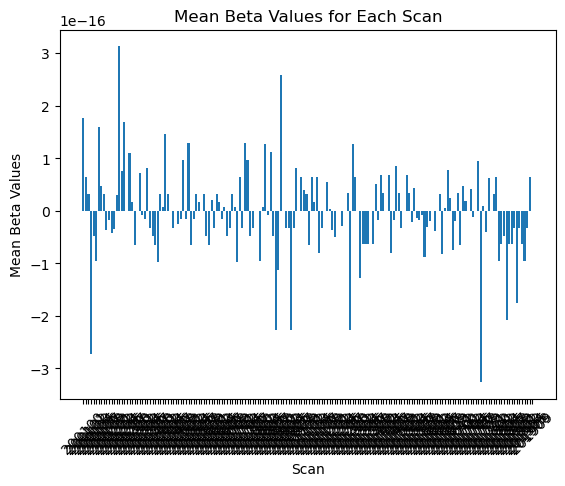

In [32]:
# --- Bar plot of residuals per dataset, per ROI ---

plt.bar(mean_betas_df['Subject'], mean_betas_df['Beta_Mean'])
plt.xlabel('Scan')
plt.ylabel('Mean Beta Values')
plt.title('Mean Beta Values for Each Scan')
plt.xticks(rotation=45)

# Show the plot
plt.show()


<Figure size 640x480 with 0 Axes>

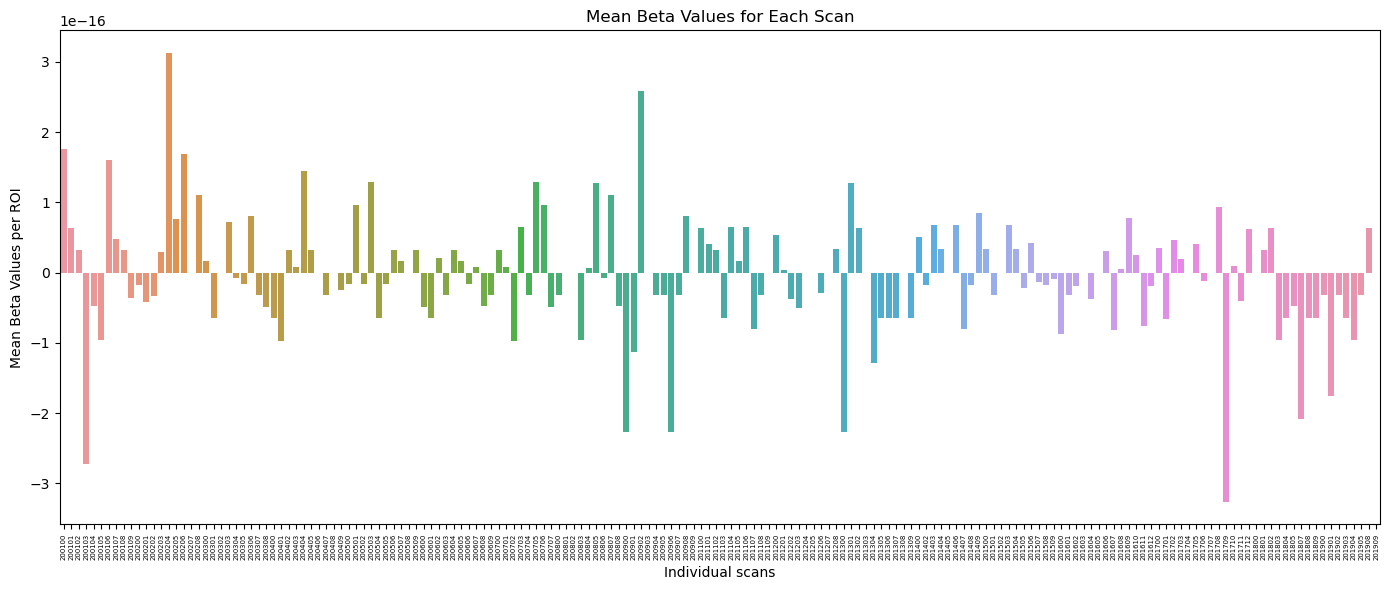

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort the DataFrame by the 'Subject' column
mean_betas_df_sorted = mean_betas_df.sort_values(by='Subject')

# Create the seaborn bar plot
plt.figure(figsize=(14, 6))
sns.barplot(data=mean_betas_df_sorted, x='Subject', y='Beta_Mean')
plt.xlabel('Individual scans')
plt.ylabel('Mean Beta Values per ROI')
plt.title('Mean Beta Values for Each Scan')
plt.xticks(rotation=90, fontsize=5)

# Show the plot
plt.tight_layout()

plt.savefig('/project/4180000.19/multirat_stim/scratch/plots/beta/glover_beta', format='svg', dpi=100)
plt.show()
